<a href="https://colab.research.google.com/github/llleyelll/food-classification/blob/main/food_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Install Kaggle
fetch the dataset from kaggle.com to colab

In [1]:
! pip install -q kaggle

Setup kaggle.json in order to fetch the dataset

In [2]:
from google.colab import files
files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

Saving kaggle.json to kaggle.json
ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              227KB  2021-05-03 13:54:12           4258  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           2454  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Job Listing 2020                     42MB  2021-03-05 06:59:52            570  
mathurinache/twitter-edge-nodes                             Twitter Edge Nodes                                342MB  2021-03-08 06:43:04            257  
dhruvildave/wikibooks-dataset             

Fetch the dataset from kaggle

In [3]:
! kaggle datasets download -d trolukovich/food11-image-dataset
! unzip food11-image-dataset.zip -d food_data

Streaming output truncated to the last 5000 lines.
  inflating: food_data/training/Soup/223.jpg  
  inflating: food_data/training/Soup/224.jpg  
  inflating: food_data/training/Soup/225.jpg  
  inflating: food_data/training/Soup/226.jpg  
  inflating: food_data/training/Soup/227.jpg  
  inflating: food_data/training/Soup/228.jpg  
  inflating: food_data/training/Soup/229.jpg  
  inflating: food_data/training/Soup/23.jpg  
  inflating: food_data/training/Soup/230.jpg  
  inflating: food_data/training/Soup/231.jpg  
  inflating: food_data/training/Soup/232.jpg  
  inflating: food_data/training/Soup/233.jpg  
  inflating: food_data/training/Soup/234.jpg  
  inflating: food_data/training/Soup/235.jpg  
  inflating: food_data/training/Soup/236.jpg  
  inflating: food_data/training/Soup/237.jpg  
  inflating: food_data/training/Soup/238.jpg  
  inflating: food_data/training/Soup/239.jpg  
  inflating: food_data/training/Soup/24.jpg  
  inflating: food_data/training/Soup/240.jpg  
  inflating

In [4]:
import matplotlib.pyplot as plt 
import tensorflow as tf
import PIL
from IPython.display import Image
import numpy as np
from random import sample
import pathlib
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
keras = tf.keras
layers = keras.layers

In [5]:
PATH = './food_data'

data_dir = pathlib.Path(PATH)
train_dir = pathlib.Path(PATH + '/training')
val_dir = pathlib.Path(PATH + '/validation')

list_ds = tf.data.Dataset.list_files(str(data_dir/'training/*/*.jpg'))

NUM_CLASSES = len(list(list_ds))
print(NUM_CLASSES)

BATCH_SIZE = 128
IMG_HEIGHT = 224
IMG_WIDTH = 224
EPOCHS=10

9866


## Data Preprocessing

Training and Validation Sets

In [6]:
# training dataset
train_ds = keras.preprocessing.image_dataset_from_directory(
  train_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

# validation dataset
validation_ds = keras.preprocessing.image_dataset_from_directory(
  val_dir,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE
)

Found 9866 files belonging to 11 classes.
Found 3430 files belonging to 11 classes.


Get class names


In [7]:
CLASS_NAMES = train_ds.class_names
print(f'Number of categories: {len(CLASS_NAMES)}')
print(CLASS_NAMES)

counts = {}
for c in CLASS_NAMES:
    counts[c] = len(os.listdir(os.path.join(train_dir, c)))
    
print(f'Total number of images in dataset: {sum(list(counts.values()))}')

Number of categories: 11
['Bread', 'Dairy product', 'Dessert', 'Egg', 'Fried food', 'Meat', 'Noodles-Pasta', 'Rice', 'Seafood', 'Soup', 'Vegetable-Fruit']
Total number of images in dataset: 9866


Example of dataset

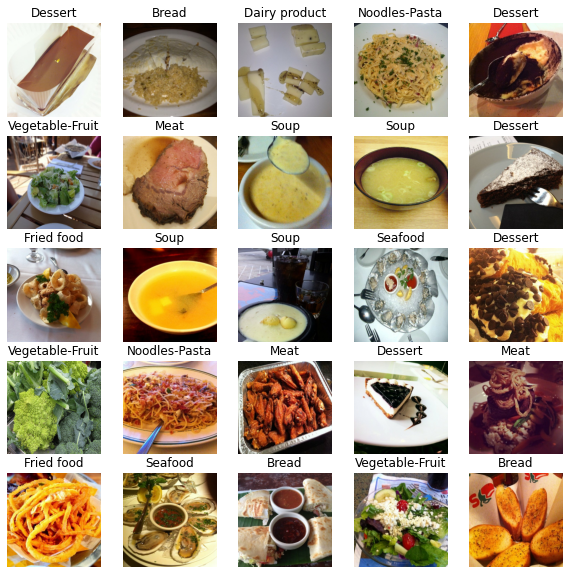

In [8]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")

## Dataset distribution

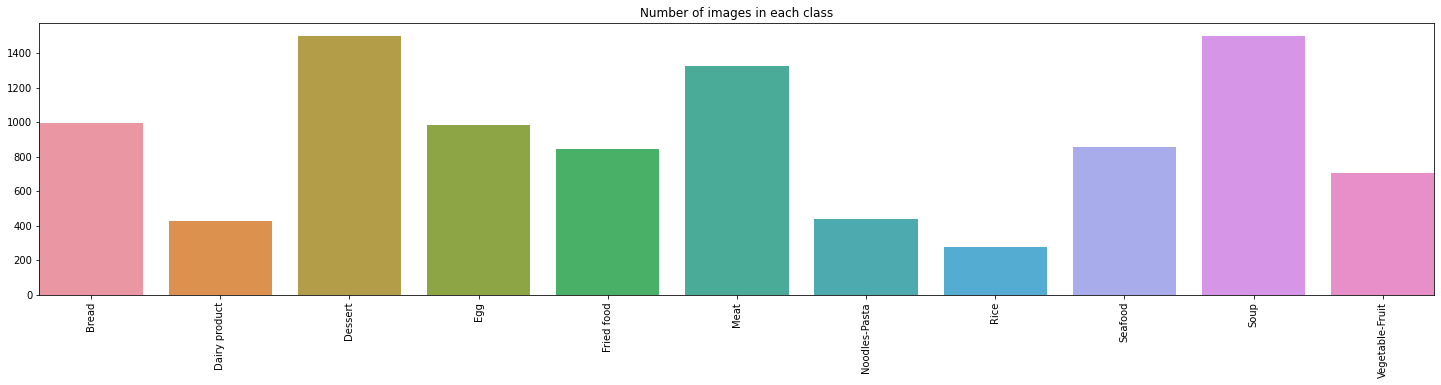

In [ ]:
fig = plt.figure(figsize = (25, 5))
sns.barplot(x = list(counts.keys()), y = list(counts.values())).set_title('Number of images in each class')
plt.xticks(rotation = 90)
plt.margins(x=0)
plt.show()

## Image Augmentation

In [9]:
experimental = keras.layers.experimental

img_augmentation = keras.Sequential(
    [
        experimental.preprocessing.RandomRotation(factor=0.2),
        experimental.preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
        experimental.preprocessing.RandomContrast(factor=0.2),
    ],
    name="img_augmentation",
)

Augmentation Result

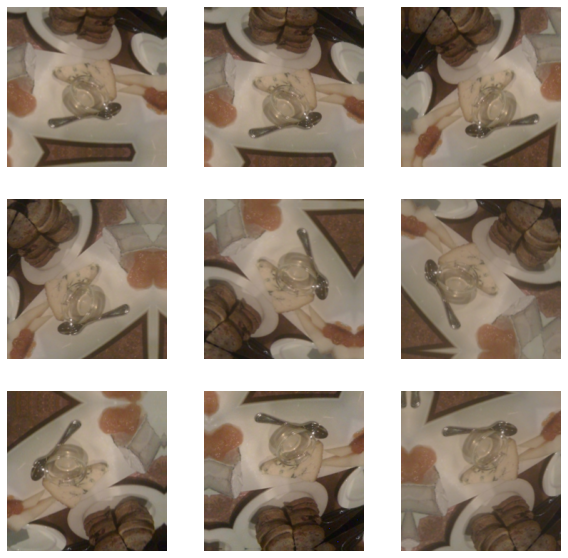

In [ ]:
for image, _ in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = img_augmentation(tf.expand_dims(image[0], axis=0))
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.axis("off")

## Build Model with CNN

In [11]:
img_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

cnn_model = keras.Sequential([
              tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
              img_augmentation,
            ])
# Step 1 - Convolution
cnn_model.add(keras.layers.Conv2D(64, 3, input_shape=(img_shape), activation='relu'))
cnn_model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
cnn_model.add(keras.layers.Dropout(0.2))
cnn_model.add(keras.layers.MaxPool2D())
cnn_model.add(keras.layers.BatchNormalization())

# Step 2 - Pooling
cnn_model.add(keras.layers.Conv2D(64, 3, strides=(2,2), activation='relu'))
cnn_model.add(keras.layers.Dropout(0.2))
cnn_model.add(keras.layers.MaxPool2D())

# Step 3 - Flattening
cnn_model.add(keras.layers.Flatten())
cnn_model.add(keras.layers.Dropout(0.2))

# Step 4 - Full connection
cnn_model.add(keras.layers.Dense(1024, activation='relu'))
cnn_model.add(keras.layers.Dense(512, activation='relu'))
cnn_model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_augmentation (Sequential (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      36928     
_________________________________________________________________
dropout (Dropout)            (None, 110, 110, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 27, 27, 64)        3

In [12]:
cnn_model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [13]:
cnn_history = cnn_model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
78/78 [==============================] - 133s 1s/step - loss: 3.9461 - accuracy: 0.1428 - val_loss: 2.2455 - val_accuracy: 0.1945
Epoch 2/10
78/78 [==============================] - 94s 1s/step - loss: 2.0102 - accuracy: 0.2876 - val_loss: 2.1780 - val_accuracy: 0.2219
Epoch 3/10
78/78 [==============================] - 94s 1s/step - loss: 1.9487 - accuracy: 0.3139 - val_loss: 1.8662 - val_accuracy: 0.3388
Epoch 4/10
78/78 [==============================] - 94s 1s/step - loss: 1.8782 - accuracy: 0.3385 - val_loss: 1.8709 - val_accuracy: 0.3636
Epoch 5/10
78/78 [==============================] - 94s 1s/step - loss: 1.8307 - accuracy: 0.3648 - val_loss: 1.8522 - val_accuracy: 0.3484
Epoch 6/10
78/78 [==============================] - 94s 1s/step - loss: 1.8027 - accuracy: 0.3694 - val_loss: 1.9713 - val_accuracy: 0.2994
Epoch 7/10
78/78 [==============================] - 94s 1s/step - loss: 1.7335 - accuracy: 0.3994 - val_loss: 1.8985 - val_accuracy: 0.3484
Epoch 8/10
78/78 [=

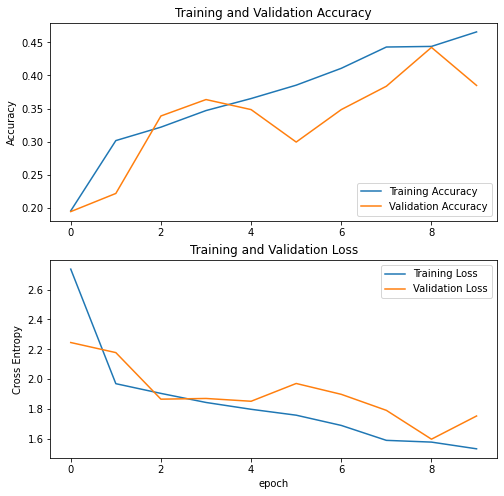

In [15]:
accuracy = cnn_history.history['accuracy']
val_accuracy = cnn_history.history['val_accuracy']

loss = cnn_history.history['loss']
val_loss = cnn_history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

plt.show()

In [14]:
# Evaluate the performance of the model
evaluate = cnn_model.evaluate(
    validation_ds, 
    batch_size=BATCH_SIZE
)

print(f'Accuracy Test of model with CNN : {evaluate[1]}')

27/27 [==============================] - 16s 485ms/step - loss: 1.7536 - accuracy: 0.3848
Accuracy Test of model with CNN : 0.38483965396881104


## Build Model with Transfer Learning

In [ ]:
img_shape=(IMG_HEIGHT, IMG_WIDTH, 3)

inputs = layers.Input(shape=img_shape)
augmented = img_augmentation(inputs)
base_model = tf.keras.applications.EfficientNetB0(
                include_top=False, 
                input_tensor=augmented, 
                weights="imagenet"
              )
base_model.trainable = False
base_model.summary()

model = keras.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dropout(0.2))

model.add(keras.layers.Dense(1024, activation='relu'))
model.add(keras.layers.Dense(512, activation='relu'))
model.add(keras.layers.Dense(NUM_CLASSES, activation='softmax'))

model.summary()

16711680/16705208 [==============================] - 0s 0us/step
Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
img_augmentation (Sequential)   (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           img_augmentation[2][0]           
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
____________________

In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=EPOCHS
)

Epoch 1/10
78/78 [==============================] - 99s 775ms/step - loss: 2.4064 - accuracy: 0.5679 - val_loss: 0.7167 - val_accuracy: 0.8259
Epoch 2/10
78/78 [==============================] - 60s 737ms/step - loss: 0.6319 - accuracy: 0.7880 - val_loss: 0.5550 - val_accuracy: 0.8306
Epoch 3/10
78/78 [==============================] - 60s 737ms/step - loss: 0.5944 - accuracy: 0.8048 - val_loss: 0.4748 - val_accuracy: 0.8478
Epoch 4/10
78/78 [==============================] - 60s 736ms/step - loss: 0.4881 - accuracy: 0.8360 - val_loss: 0.4004 - val_accuracy: 0.8706
Epoch 5/10
78/78 [==============================] - 60s 735ms/step - loss: 0.4634 - accuracy: 0.8409 - val_loss: 0.4030 - val_accuracy: 0.8697
Epoch 6/10
78/78 [==============================] - 60s 737ms/step - loss: 0.4537 - accuracy: 0.8465 - val_loss: 0.4240 - val_accuracy: 0.8647
Epoch 7/10
78/78 [==============================] - 60s 741ms/step - loss: 0.4131 - accuracy: 0.8557 - val_loss: 0.4254 - val_accuracy: 0.8700

## Evaluating Performance of Model

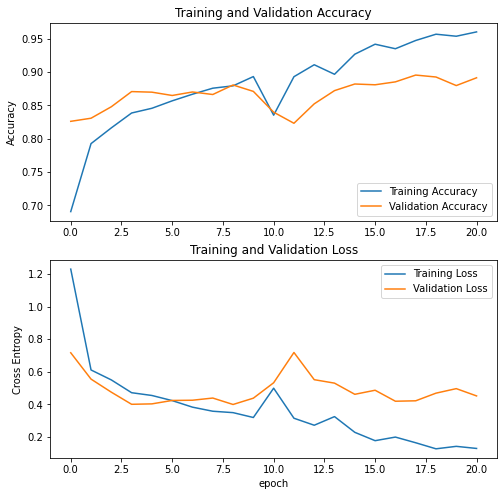

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('epoch')
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    validation_ds, 
    batch_size=BATCH_SIZE
)

print(f'Accuracy Test : {evaluate[1]}')

27/27 [==============================] - 16s 476ms/step - loss: 0.4380 - accuracy: 0.8708
Accuracy Test : 0.8708454966545105


## Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
# Fine tune from layer 100
fine_tune_at = 100

# Freeze all the layers before the fine_tune_at layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  238


In [ ]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1311744   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 9866)              5

In [ ]:
fine_tune_epochs = 10
total_epochs =  EPOCHS + fine_tune_epochs

history_fine = model.fit(
                  train_ds,
                  validation_data=validation_ds,
                  epochs=total_epochs,
                  initial_epoch=history.epoch[-1]
                )

Epoch 10/20
78/78 [==============================] - 77s 954ms/step - loss: 0.4992 - accuracy: 0.8352 - val_loss: 0.5326 - val_accuracy: 0.8397
Epoch 11/20
78/78 [==============================] - 76s 940ms/step - loss: 0.3149 - accuracy: 0.8929 - val_loss: 0.7184 - val_accuracy: 0.8230
Epoch 12/20
78/78 [==============================] - 76s 941ms/step - loss: 0.2719 - accuracy: 0.9108 - val_loss: 0.5515 - val_accuracy: 0.8522
Epoch 13/20
78/78 [==============================] - 76s 942ms/step - loss: 0.3249 - accuracy: 0.8965 - val_loss: 0.5303 - val_accuracy: 0.8720
Epoch 14/20
78/78 [==============================] - 76s 944ms/step - loss: 0.2284 - accuracy: 0.9266 - val_loss: 0.4617 - val_accuracy: 0.8819
Epoch 15/20
78/78 [==============================] - 76s 945ms/step - loss: 0.1771 - accuracy: 0.9416 - val_loss: 0.4867 - val_accuracy: 0.8808
Epoch 16/20
78/78 [==============================] - 76s 943ms/step - loss: 0.1992 - accuracy: 0.9348 - val_loss: 0.4192 - val_accuracy:

In [ ]:
accuracy += history_fine.history['accuracy']
val_accuracy += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

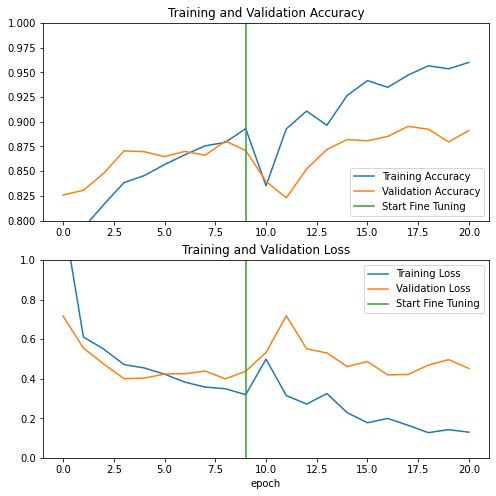

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([EPOCHS-1,EPOCHS-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([EPOCHS-1,EPOCHS-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')

plt.show()

In [ ]:
# Evaluate the performance of the model
evaluate = model.evaluate(
    validation_ds, 
    batch_size=BATCH_SIZE
)

print(f'Accuracy Test : {evaluate[1]}')

27/27 [==============================] - 16s 476ms/step - loss: 0.4518 - accuracy: 0.8913
Accuracy Test : 0.891253650188446


Save model

In [ ]:
model.save('trained.h5')

## Prediction

In [ ]:
from keras.preprocessing import image

prediction = []
original = []
images = []
path_eval = PATH + '/evaluation'

for i in os.listdir(path_eval):
    for file_name in os.listdir(os.path.join(path_eval, i)):
      # open image from evaluation dir
      img = PIL.Image.open(os.path.join(path_eval, i, file_name))
      # resize image to 224 x 224
      img = img.resize((224,224))
      images.append(img)
      # convert image to numpy array format 
      img_np = image.img_to_array(img)
      img_np = np.expand_dims(img_np, axis=0)
      image_matrix = np.vstack([img_np])
      # making prediction of the model
      result = model.predict(image_matrix, batch_size=BATCH_SIZE)
      # get the index of the highest value in the prediction
      predict = np.argmax(result[0])
      original.append(i)
      prediction.append(CLASS_NAMES[predict])

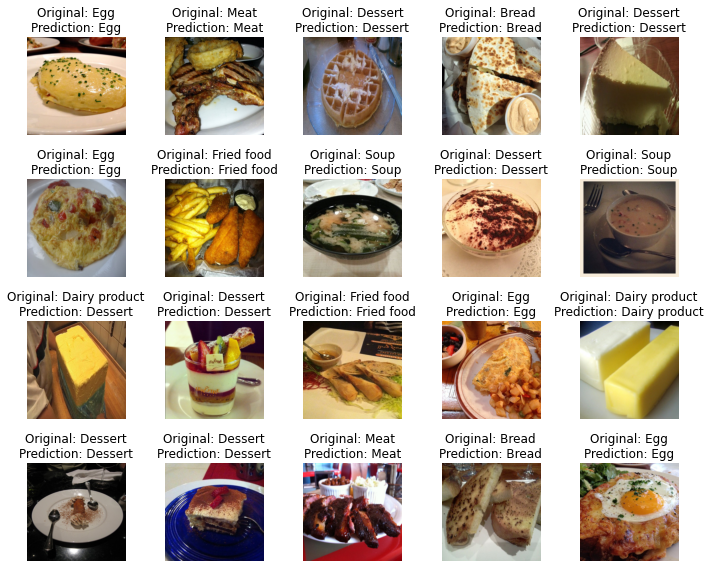

In [ ]:
import random

# Visualizing the results
fig=plt.figure(figsize = (10,10))
for i in range(20):
    j = random.randint(0,len(images))
    fig.add_subplot(5, 5, i + 1)
    plt.title("Original: " + original[j] + "\nPrediction: " + prediction[j])
    plt.imshow(images[j])
    plt.axis("off")
fig.tight_layout()
plt.show()

## Classification Report

In [ ]:
print(classification_report(np.asarray(prediction), np.asarray(original)))

                 precision    recall  f1-score   support

          Bread       0.90      0.90      0.90       369
  Dairy product       0.83      0.92      0.87       134
        Dessert       0.88      0.89      0.88       496
            Egg       0.93      0.87      0.90       357
     Fried food       0.89      0.92      0.90       279
           Meat       0.94      0.92      0.93       437
  Noodles-Pasta       0.99      0.96      0.97       151
           Rice       0.84      0.99      0.91        82
        Seafood       0.93      0.95      0.94       296
           Soup       0.96      0.98      0.97       494
Vegetable-Fruit       0.98      0.90      0.94       252

       accuracy                           0.92      3347
      macro avg       0.92      0.93      0.92      3347
   weighted avg       0.92      0.92      0.92      3347



## Confusion Matrix

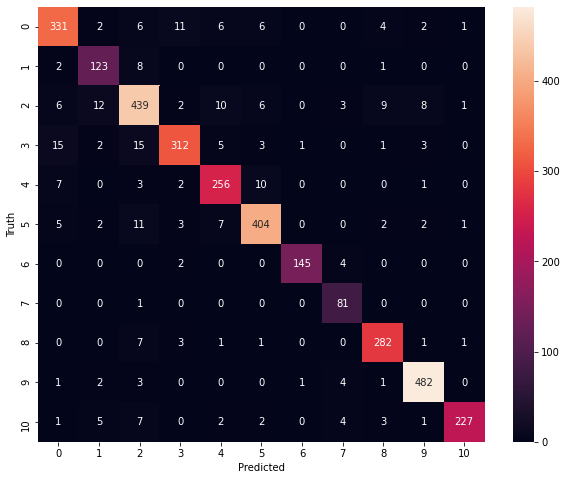

In [ ]:
plt.figure(figsize = (10, 8))
cnf_matrix = confusion_matrix(np.asarray(prediction), np.asarray(original))
sns.heatmap(
    cnf_matrix, 
    annot = True, 
    fmt = "d"
)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

## F1 score

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(prediction, original, average='weighted')
print(f'F1 score: {f1}')

F1 score: 0.9209575836792149


## True Positive Rate (TPR) and False Positive Rate (FPR)

In [ ]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

FP = FP.astype(float)
FN = FN.astype(float)
TP = TP.astype(float)
TN = TN.astype(float)

TPR = TP/(TP+FN)
FPR = FP/(FP+TN)

print(f'TPR: {TPR}')
print(f'FPR: {FPR}')

TPR: [0.89701897 0.91791045 0.88508065 0.87394958 0.91756272 0.92448513
 0.9602649  0.98780488 0.9527027  0.9757085  0.90079365]
FPR: [0.01242445 0.00778089 0.021396   0.00769231 0.0101043  0.00962199
 0.00062578 0.00459418 0.00688299 0.00630915 0.00129241]
